# PySpark and Hadoop Notebook

This notebook will be used to demonstrate and implement **PySpark** and **Hadoop** functionalities. The aim of this notebook is to work with distributed data processing and big data analytics using PySpark, the Python API for Spark, and leverage the Hadoop ecosystem for storage and resource management.

### Goals of the Notebook:
1. **PySpark**:
   - The notebook will use PySpark to perform large-scale data processing tasks such as filtering, aggregating, and transforming data.
   - It will showcase how PySpark can be used to process data in parallel across multiple nodes of a cluster.

2. **Hadoop**:
   - This notebook will also interact with **Hadoop**, particularly with the Hadoop Distributed File System (HDFS) for storing large datasets.


This notebook will serve as a practical example for working with big data and distributed computing frameworks like PySpark and Hadoop. It will lay the foundation for building scalable data pipelines and machine learning workflows.

This notebook will be mostly used in the VM with pyspark, The github repo was cloned and accessed through the terminal in ubuntu for seemless coordination


# Pyspark is initialised through the ubuntu terminal

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf

# Optimized SparkConf
conf = (
    SparkConf()
    .set("spark.executor.memory", "2g")  # Set executor memory
    .set("spark.driver.memory", "2g")  # Set driver memory
    .set("spark.executor.cores", "2")  # Number of cores per executor
    .set("spark.sql.shuffle.partitions", "50")  # Optimize shuffle performance
    .set("spark.default.parallelism", "50")  # Improve parallelism
)

# Get existing SparkSession and apply configurations
sc = SparkSession.getActiveSession()

if sc:
    print("===== Spark Session Info =====")
    print(f"App Name: {sc.sparkContext.appName}")
    print(f"Master: {sc.sparkContext.master}")
    print(f"Spark UI: {sc.sparkContext.uiWebUrl}")
    print(f"Shuffle Partitions: {sc.conf.get('spark.sql.shuffle.partitions')}")
else:
    print("No active SparkSession found.")



===== Spark Session Info =====
App Name: PySparkShell
Master: local[*]
Spark UI: http://10.0.2.15:4040
Shuffle Partitions: 200


##  The Spark master is configured as:

Master: local[*]

This means that Spark is running in local mode, utilizing all available CPU cores ([*]). There is no cluster manager such as YARN or Mesos in this configuration; instead, Spark runs in a single JVM instance on the local machine.

sc represents the SparkContext, which is the entry point for Spark functionalities.

The master URL (local[*]) indicates that the application is running locally without a distributed cluster.

SparkContext initializes the execution environment and coordinates task execution across the available resources.

## SparkSession

The SparkSession is the unified entry point for working with Spark DataFrames and SQL:

spark

By default, SparkSession is initialized as:

AppName: PySparkShell

Key Points:

SparkSession provides APIs for working with structured data and integrates with Hive when Hive support is enabled.

It allows SQL operations, DataFrame API usage, and interaction with data stored in Hadoop.

## Worker Nodes

Since Spark is running in local mode, there are no separate worker nodes. Instead, all tasks run on the local machine. In a distributed setup, worker nodes would execute tasks assigned by the driver program.

## Resource Manager

In a fully distributed setup, a resource manager like YARN or Mesos would manage resource allocation. However, since the master is local[*], Spark does not use an external resource manager. Instead, it relies on the local operating system to allocate resources.

## Spark UI

The Spark UI provides runtime monitoring and job execution details. It can be accessed (if enabled) via:

http://localhost:4040

Key Insights from Spark UI:

Active jobs and completed jobs

Task execution details

Stage breakdowns

Memory and storage usage

## Data Storage in Hadoop

The data is stored in Hadoop's HDFS (Hadoop Distributed File System). Spark interacts with Hadoop using:

hadoop_path = "hdfs://namenode:9000/user1/stock_data.csv"

http://localhost:9870/dfshealth.html#tab-overview

Key Aspects of HDFS Storage:

Spark reads and writes data directly from HDFS.

HDFS provides fault tolerance and high availability.

Data is split into blocks and distributed across multiple nodes (if running in cluster mode).

In [2]:
# importing the necessary libraries 
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType, DateType, StringType
from pyspark.sql.functions import col, to_timestamp
import matplotlib.pyplot as plt
import pandas as pd 
import pyspark.sql.functions as fn

In [3]:
# Define the schema
schema = StructType([
    StructField("_c0", StringType(), True), #This is the index, if i didnt define it here, the df wouldnt work 
    StructField("date", DateType(), True),  # Read as DateType
    StructField("close", FloatType(), True),
    StructField("high", FloatType(), True),
    StructField("low", FloatType(), True),
    StructField("open", FloatType(), True),
    StructField("volume", FloatType(), True),
    StructField("adjClose", FloatType(), True),
    StructField("adjHigh", FloatType(), True),
    StructField("adjLow", FloatType(), True),
    StructField("adjOpen", FloatType(), True),
    StructField("adjVolume", FloatType(), True),
    StructField("divCash", FloatType(), True),
    StructField("splitFactor", FloatType(), True)
])

# Now, read the data with this schema http://localhost:9870/dfshealth.html#tab-overview

df = spark.read.option('header','true').schema(schema).csv("/user1/stock_data.csv", header=True)


#Caching the dataset to store it in memory for faster access 
#df.cache()


#Dropping the unecessary index column 
df = df.drop("_c0")

#using .persist() as it allows more flexibility if the dataset increases in size 
from pyspark import StorageLevel
df.cache() # Suitable for smaller datasets 
print(df.is_cached)

#df.persist(StorageLevel.MEMORY_AND_DISK)

df.show(5)


True


+----------+-------+-------+------+------+-----------+---------+---------+---------+---------+------------+-------+-----------+
|      date|  close|   high|   low|  open|     volume| adjClose|  adjHigh|   adjLow|  adjOpen|   adjVolume|divCash|splitFactor|
+----------+-------+-------+------+------+-----------+---------+---------+---------+---------+------------+-------+-----------+
|2015-05-27|132.045| 132.26|130.05|130.34|4.5833248E7|29.609407|29.657618|29.162054|29.227081|1.83332992E8|    0.0|        1.0|
|2015-05-28| 131.78| 131.95| 131.1|131.86|3.0733308E7|29.549984|29.588104|29.397503|29.567923|1.22933232E8|    0.0|        1.0|
|2015-05-29| 130.28| 131.45| 129.9|131.23|5.0884452E7|29.213627|29.475985|29.128418|29.426653|2.03537808E8|    0.0|        1.0|
|2015-06-01|130.535| 131.39|130.05| 131.2|3.2112796E7| 29.27081| 29.46253|29.162054|29.419926|1.28451184E8|    0.0|        1.0|
|2015-06-02| 129.96|130.655|129.32|129.86|3.3667628E7|29.141872|29.297716| 28.99836|29.119448|1.34670512

In [4]:
df.printSchema()

root
 |-- date: date (nullable = true)
 |-- close: float (nullable = true)
 |-- high: float (nullable = true)
 |-- low: float (nullable = true)
 |-- open: float (nullable = true)
 |-- volume: float (nullable = true)
 |-- adjClose: float (nullable = true)
 |-- adjHigh: float (nullable = true)
 |-- adjLow: float (nullable = true)
 |-- adjOpen: float (nullable = true)
 |-- adjVolume: float (nullable = true)
 |-- divCash: float (nullable = true)
 |-- splitFactor: float (nullable = true)



In [5]:
# Observing the number of rows and number of distinct rows 
print('Count of rows: {0}'.format(df.count()))
print('Count of Distinct rows: {0}'.format(df.distinct().count()))

Count of rows: 2456
Count of Distinct rows: 2456


## There are no duplicate rows 

# Descriptive statistics 

## Understanding the data 

The summary statistics presented above provide a comprehensive view of the stock's performance across the observed period. These values help us understand the central tendencies, variability, and extreme values of the stock’s characteristics, including the close, high, low, open, and volume.

In [6]:
# computing statistics for the df 
import pyspark.sql.types as typ

In [7]:
#Selecting the columns for descriptive stats
numerical = ['close', 'high', 'low' ,'open', 'volume' ]

In [8]:
#Calculcating descriptive stats
desc = df.describe(numerical)
desc.show()

25/03/20 11:12:21 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+------------------+--------------------+
|summary|             close|              high|               low|              open|              volume|
+-------+------------------+------------------+------------------+------------------+--------------------+
|  count|              2456|              2456|              2456|              2456|                2456|
|   mean|173.79326745197906| 175.4450579497247|171.93211302617473| 173.6097437178273|5.4660212165309444E7|
| stddev|60.313305459379926|60.914565968673145| 59.45709172129202|60.101404836634735|3.4706330792145714E7|
|    min|             90.34|             91.67|             89.47|              90.0|         1.1362045E7|
|    max|            506.09|            515.14|            500.33|            514.79|        3.32607168E8|
+-------+------------------+------------------+------------------+------------------+--------------------+



## calculating skewness

In [9]:
df.agg({'close':'skewness','high':'skewness','low':'skewness','open':'skewness','volume':'skewness'}).show()

+-----------------+-----------------+-----------------+------------------+------------------+
|   skewness(open)|    skewness(low)|  skewness(close)|  skewness(volume)|    skewness(high)|
+-----------------+-----------------+-----------------+------------------+------------------+
|1.786107003206662|1.768984471711963|1.786086924017782|1.9708489023184848|1.7930588741205324|
+-----------------+-----------------+-----------------+------------------+------------------+



## Kurtosis 

For stock market data, such as the close, high, low, open, and volume, analyzing kurtosis helps to identify:

- Volatility: Understanding how volatile the stock is by examining extreme price fluctuations. High kurtosis in the close or high prices, for example, could indicate periods of significant market instability.


- Market Sentiment: Extreme deviations from the normal distribution in the volume data can suggest unusual trading activity, such as panic selling or speculative trading.


- Risk Assessment: By identifying high kurtosis, investors or analysts can assess the risk associated with the stock. Stocks with high kurtosis are more likely to experience extreme price changes, both positive and negative.

In [10]:
df.agg({'close':'kurtosis','high':'kurtosis','low':'kurtosis','open':'kurtosis','volume':'kurtosis'}).show()

+----------------+-----------------+-----------------+-----------------+-----------------+
|  kurtosis(open)|    kurtosis(low)|  kurtosis(close)| kurtosis(volume)|   kurtosis(high)|
+----------------+-----------------+-----------------+-----------------+-----------------+
|5.01023922693423|4.906201790488905|4.980452271925814|6.839542172634403|5.009127891381192|
+----------------+-----------------+-----------------+-----------------+-----------------+



##  Calculating correlations in the data 

In [11]:
n_numerical = len(numerical)

corr = []

for i in range(0,n_numerical):
    temp = [None] *i
    
    for j in range(i, n_numerical):
        temp.append(df.corr(numerical[i],numerical[j]))
    corr.append(temp)
corr
    

[[1.0,
  0.9995186801885134,
  0.99951800319506,
  0.9990405394637801,
  -0.21729086528382321],
 [None, 1.0, 0.9993182294262527, 0.9995384328613139, -0.20759555341824174],
 [None, None, 1.0, 0.9995204001007263, -0.22607294760695384],
 [None, None, None, 1.0, -0.21614376894971463],
 [None, None, None, None, 1.0]]

### Justification for Computing Outliers Only for the volume Column

In this analysis, the decision to compute outliers specifically for the volume column,
rather than for all columns in the dataset, is driven by the nature and role of the data,
as well as the goal of the analysis. 
Here's why we focus on the volume column:

Computing outliers for the volume column because it represents a variable with greater potential for meaningful extreme values that could indicate market events worth investigating further. 

For other columns, such as prices or adjusted prices, outlier detection may not provide the same level of insight or relevance, and could potentially remove important market variations. Therefore, focusing on the volume column allows us to prioritize the analysis of extreme trading activity while maintaining the integrity of the price-related columns.

In [12]:
#computing outliers for volume column
cols = ['volume']
bounds ={}

for col in cols:
    quantiles = df.approxQuantile(col,[0.25, 0.75],0.05)
    IQR =quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]
    
bounds

{'volume': [-22918138.0, 119541206.0]}

In [13]:
# Now lets flag any days that had outliers in volume traded 
outliers = df.select(*['volume']+ [
    (
        (df[c] < bounds[c][0]) |
        (df[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers.show()

+-----------+--------+
|     volume|volume_o|
+-----------+--------+
|4.5833248E7|   false|
|3.0733308E7|   false|
|5.0884452E7|   false|
|3.2112796E7|   false|
|3.3667628E7|   false|
|3.0983542E7|   false|
| 3.845012E7|   false|
|  3.56268E7|   false|
|5.2674784E7|   false|
| 5.607542E7|   false|
|3.9087248E7|   false|
|3.5390888E7|   false|
|3.6886248E7|   false|
|4.3988944E7|   false|
|3.1494132E7|   false|
|3.2918072E7|   false|
| 3.540722E7|   false|
|5.4716888E7|   false|
|3.4039344E7|   false|
|3.0268864E7|   false|
+-----------+--------+
only showing top 20 rows



## Running transformations and actions 

In [14]:
# 
df_miss = df
df_miss.rdd.map(lambda row: (row['date'],sum([c == None for c in row]))).collect()


[(datetime.date(2015, 5, 27), 0),
 (datetime.date(2015, 5, 28), 0),
 (datetime.date(2015, 5, 29), 0),
 (datetime.date(2015, 6, 1), 0),
 (datetime.date(2015, 6, 2), 0),
 (datetime.date(2015, 6, 3), 0),
 (datetime.date(2015, 6, 4), 0),
 (datetime.date(2015, 6, 5), 0),
 (datetime.date(2015, 6, 8), 0),
 (datetime.date(2015, 6, 9), 0),
 (datetime.date(2015, 6, 10), 0),
 (datetime.date(2015, 6, 11), 0),
 (datetime.date(2015, 6, 12), 0),
 (datetime.date(2015, 6, 15), 0),
 (datetime.date(2015, 6, 16), 0),
 (datetime.date(2015, 6, 17), 0),
 (datetime.date(2015, 6, 18), 0),
 (datetime.date(2015, 6, 19), 0),
 (datetime.date(2015, 6, 22), 0),
 (datetime.date(2015, 6, 23), 0),
 (datetime.date(2015, 6, 24), 0),
 (datetime.date(2015, 6, 25), 0),
 (datetime.date(2015, 6, 26), 0),
 (datetime.date(2015, 6, 29), 0),
 (datetime.date(2015, 6, 30), 0),
 (datetime.date(2015, 7, 1), 0),
 (datetime.date(2015, 7, 2), 0),
 (datetime.date(2015, 7, 6), 0),
 (datetime.date(2015, 7, 7), 0),
 (datetime.date(2015, 7, 

In [15]:
#Spark optimises for smaller data by using a single partition for small data, this is for efficiency,
# avoiding unecessary overheads 
print(df_miss.rdd.getNumPartitions())

1


In [16]:
# Displaying any missing values on a particular date 
df_miss.where("date == '2015-05-27'").show()

+----------+-------+------+------+------+-----------+---------+---------+---------+---------+------------+-------+-----------+
|      date|  close|  high|   low|  open|     volume| adjClose|  adjHigh|   adjLow|  adjOpen|   adjVolume|divCash|splitFactor|
+----------+-------+------+------+------+-----------+---------+---------+---------+---------+------------+-------+-----------+
|2015-05-27|132.045|132.26|130.05|130.34|4.5833248E7|29.609407|29.657618|29.162054|29.227081|1.83332992E8|    0.0|        1.0|
+----------+-------+------+------+------+-----------+---------+---------+---------+---------+------------+-------+-----------+



In [17]:
# what is the percentage of missing observations we see in each column
df_miss.agg(*[
    (1-(fn.count(c)/fn.count('*'))).alias(c + '_missing')
    for c in df_miss.columns
]).show()

+------------+-------------+------------+-----------+------------+--------------+----------------+---------------+--------------+---------------+-----------------+---------------+-------------------+
|date_missing|close_missing|high_missing|low_missing|open_missing|volume_missing|adjClose_missing|adjHigh_missing|adjLow_missing|adjOpen_missing|adjVolume_missing|divCash_missing|splitFactor_missing|
+------------+-------------+------------+-----------+------------+--------------+----------------+---------------+--------------+---------------+-----------------+---------------+-------------------+
|         0.0|          0.0|         0.0|        0.0|         0.0|           0.0|             0.0|            0.0|           0.0|            0.0|              0.0|            0.0|                0.0|
+------------+-------------+------------+-----------+------------+--------------+----------------+---------------+--------------+---------------+-----------------+---------------+-------------------+



# There are no missing values in the dataset so no imputation will be necessary, as this data is sequential no duplicate checks will be performed

In [18]:
# to calculate the daily price change by subtracting the 
#'low' price from the 'high' price for each row and pairing it with the 'date'
rdd1 = df.rdd

#Gettign the number of partitions 
print(rdd1.getNumPartitions())


daily_change_rdd = rdd1.map(lambda row: (row['date'], row['high'] -row['low']))
print(daily_change_rdd.take(5))

1
[(datetime.date(2015, 5, 27), 2.209991455078125), (datetime.date(2015, 5, 28), 0.8499908447265625), (datetime.date(2015, 5, 29), 1.5500030517578125), (datetime.date(2015, 6, 1), 1.339996337890625), (datetime.date(2015, 6, 2), 1.334991455078125)]


In [19]:
# identify days with high trading volume greater than the mean of 5.4660212165309444E7
high_volume = rdd1.filter(lambda row: row['volume'] > 5.4660212165309444E7)
high_volume.count()
high_volume.take(1)



[Row(date=datetime.date(2015, 6, 9), close=127.41999816894531, high=128.0800018310547, low=125.62000274658203, open=126.69999694824219, volume=56075420.0, adjClose=28.572309494018555, adjHigh=28.720306396484375, adjLow=28.168682098388672, adjOpen=28.410858154296875, adjVolume=224301680.0, divCash=0.0, splitFactor=1.0)]

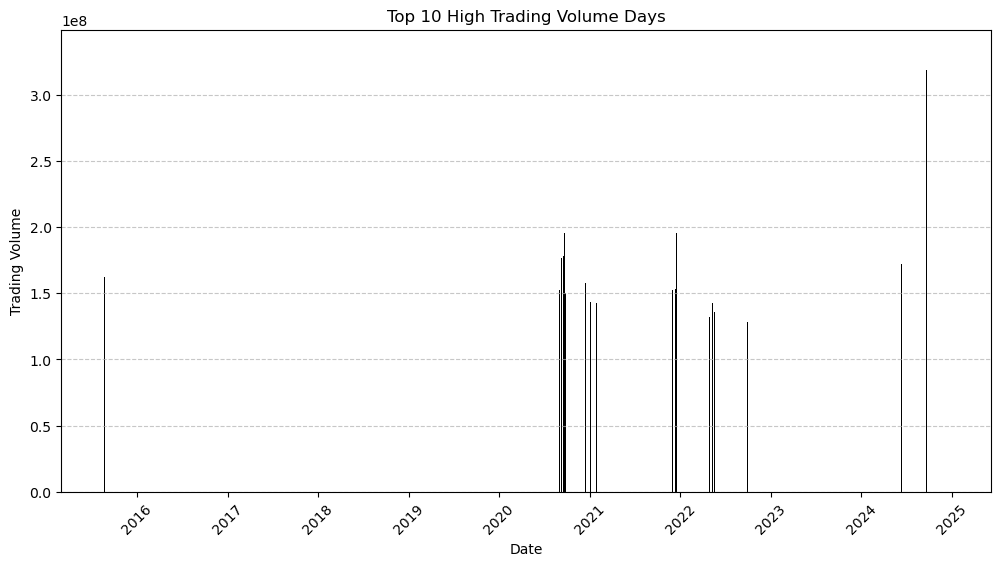

In [20]:

# Convert RDD to DataFrame
high_volume_df = high_volume.toDF()

# Select necessary columns and convert to Pandas
high_volume_pd = high_volume_df.select("date", "volume").toPandas()

# Convert 'date' column to datetime format (if it's a string)
high_volume_pd["date"] = pd.to_datetime(high_volume_pd["date"])

# Sort by volume (descending) and keep only the top 10
top_10_high_volume = high_volume_pd.nlargest(100, "volume")

# Plot the top 10 high-volume days
plt.figure(figsize=(12, 6))
plt.bar(top_10_high_volume["date"], top_10_high_volume["volume"], color="black")

# Formatting the chart
plt.title("Top 10 High Trading Volume Days")
plt.xlabel("Date")
plt.ylabel("Trading Volume")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()



## Query data using SQL


In [21]:
# Register the DataFrame as a temporary view
SQL = df.createOrReplaceTempView("my_temp_view")

# Execute SQL queries on the view
result = spark.sql("SELECT * FROM my_temp_view LIMIT 5")

# Show the result of the query
result.show()


+----------+-------+-------+------+------+-----------+---------+---------+---------+---------+------------+-------+-----------+
|      date|  close|   high|   low|  open|     volume| adjClose|  adjHigh|   adjLow|  adjOpen|   adjVolume|divCash|splitFactor|
+----------+-------+-------+------+------+-----------+---------+---------+---------+---------+------------+-------+-----------+
|2015-05-27|132.045| 132.26|130.05|130.34|4.5833248E7|29.609407|29.657618|29.162054|29.227081|1.83332992E8|    0.0|        1.0|
|2015-05-28| 131.78| 131.95| 131.1|131.86|3.0733308E7|29.549984|29.588104|29.397503|29.567923|1.22933232E8|    0.0|        1.0|
|2015-05-29| 130.28| 131.45| 129.9|131.23|5.0884452E7|29.213627|29.475985|29.128418|29.426653|2.03537808E8|    0.0|        1.0|
|2015-06-01|130.535| 131.39|130.05| 131.2|3.2112796E7| 29.27081| 29.46253|29.162054|29.419926|1.28451184E8|    0.0|        1.0|
|2015-06-02| 129.96|130.655|129.32|129.86|3.3667628E7|29.141872|29.297716| 28.99836|29.119448|1.34670512

In [22]:
result = spark.sql("SELECT MAX(close) AS max_close, MIN(close) AS min_close FROM my_temp_view")
result.show()


+---------+---------+
|max_close|min_close|
+---------+---------+
|   506.09|    90.34|
+---------+---------+



In [23]:
#Average close for ceratins months 
query = """
SELECT YEAR(date) AS year, MONTH(date) AS month, AVG(close) AS avg_close
FROM my_temp_view
GROUP BY YEAR(date), MONTH(date)
ORDER BY year, month
"""
result = spark.sql(query)
result.show()


+----+-----+------------------+
|year|month|         avg_close|
+----+-----+------------------+
|2015|    5| 131.3683319091797|
|2015|    6|127.80636353926225|
|2015|    7|125.33545476740056|
|2015|    8|113.39476231166294|
|2015|    9|112.78095172700428|
|2015|   10|113.35999991677024|
|2015|   11|118.16224975585938|
|2015|   12| 111.7268180847168|
|2016|    1| 98.42894624408923|
|2016|    2| 95.74650001525879|
|2016|    3|104.26727294921875|
|2016|    4|106.73904782249814|
|2016|    5| 94.97476159958612|
|2016|    6| 96.62227283824573|
|2016|    7|  98.5564998626709|
|2016|    8|107.66521818741508|
|2016|    9|110.85714249383835|
|2016|   10|115.70714314778645|
|2016|   11|110.15428524925595|
|2016|   12|114.33571443103608|
+----+-----+------------------+
only showing top 20 rows



In [24]:
#Find the Top 5 Days with the Highest Volume Traded
query = """
SELECT date, volume
FROM my_temp_view
ORDER BY volume DESC
LIMIT 5
"""
result = spark.sql(query)
result.show()


+----------+------------+
|      date|      volume|
+----------+------------+
|2020-09-04|3.32607168E8|
|2024-09-20|3.18679872E8|
|2020-09-18|2.87104896E8|
|2020-10-13|2.62330448E8|
|2020-09-03|2.57599648E8|
+----------+------------+



In [25]:
#Runnign a query to get percentage change from day to day 
query = """
SELECT date, close, previous_close, 
       ((close - previous_close) / previous_close) * 100 AS percent_change
FROM (
    SELECT date, close,
           LAG(close, 1) OVER (ORDER BY date) AS previous_close
    FROM my_temp_view
) AS subquery
WHERE previous_close IS NOT NULL
"""
result = spark.sql(query)
result.show()



25/03/20 11:12:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/03/20 11:12:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/03/20 11:12:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/03/20 11:12:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/03/20 11:12:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+-------+--------------+--------------------+
|      date|  close|previous_close|      percent_change|
+----------+-------+--------------+--------------------+
|2015-05-28| 131.78|       132.045|-0.20068869955178714|
|2015-05-29| 130.28|        131.78| -1.1382607481368832|
|2015-06-01|130.535|        130.28| 0.19573601873031599|
|2015-06-02| 129.96|       130.535| -0.4404925361863631|
|2015-06-03| 130.12|        129.96| 0.12310587492701414|
|2015-06-04| 129.36|        130.12| -0.5840720376230248|
|2015-06-05| 128.65|        129.36| -0.5488610934734116|
|2015-06-08|  127.8|        128.65| -0.6607002604372376|
|2015-06-09| 127.42|         127.8| -0.2973434066809854|
|2015-06-10| 128.88|        127.42|  1.1458222687551562|
|2015-06-11| 128.59|        128.88| -0.2250221399243217|
|2015-06-12| 127.17|        128.59| -1.1042835441211476|
|2015-06-15| 126.92|        127.17|-0.19658724825007473|
|2015-06-16|  127.6|        126.92|  0.5357708123117222|
|2015-06-17|  127.3|         12

## Data Visualisations 

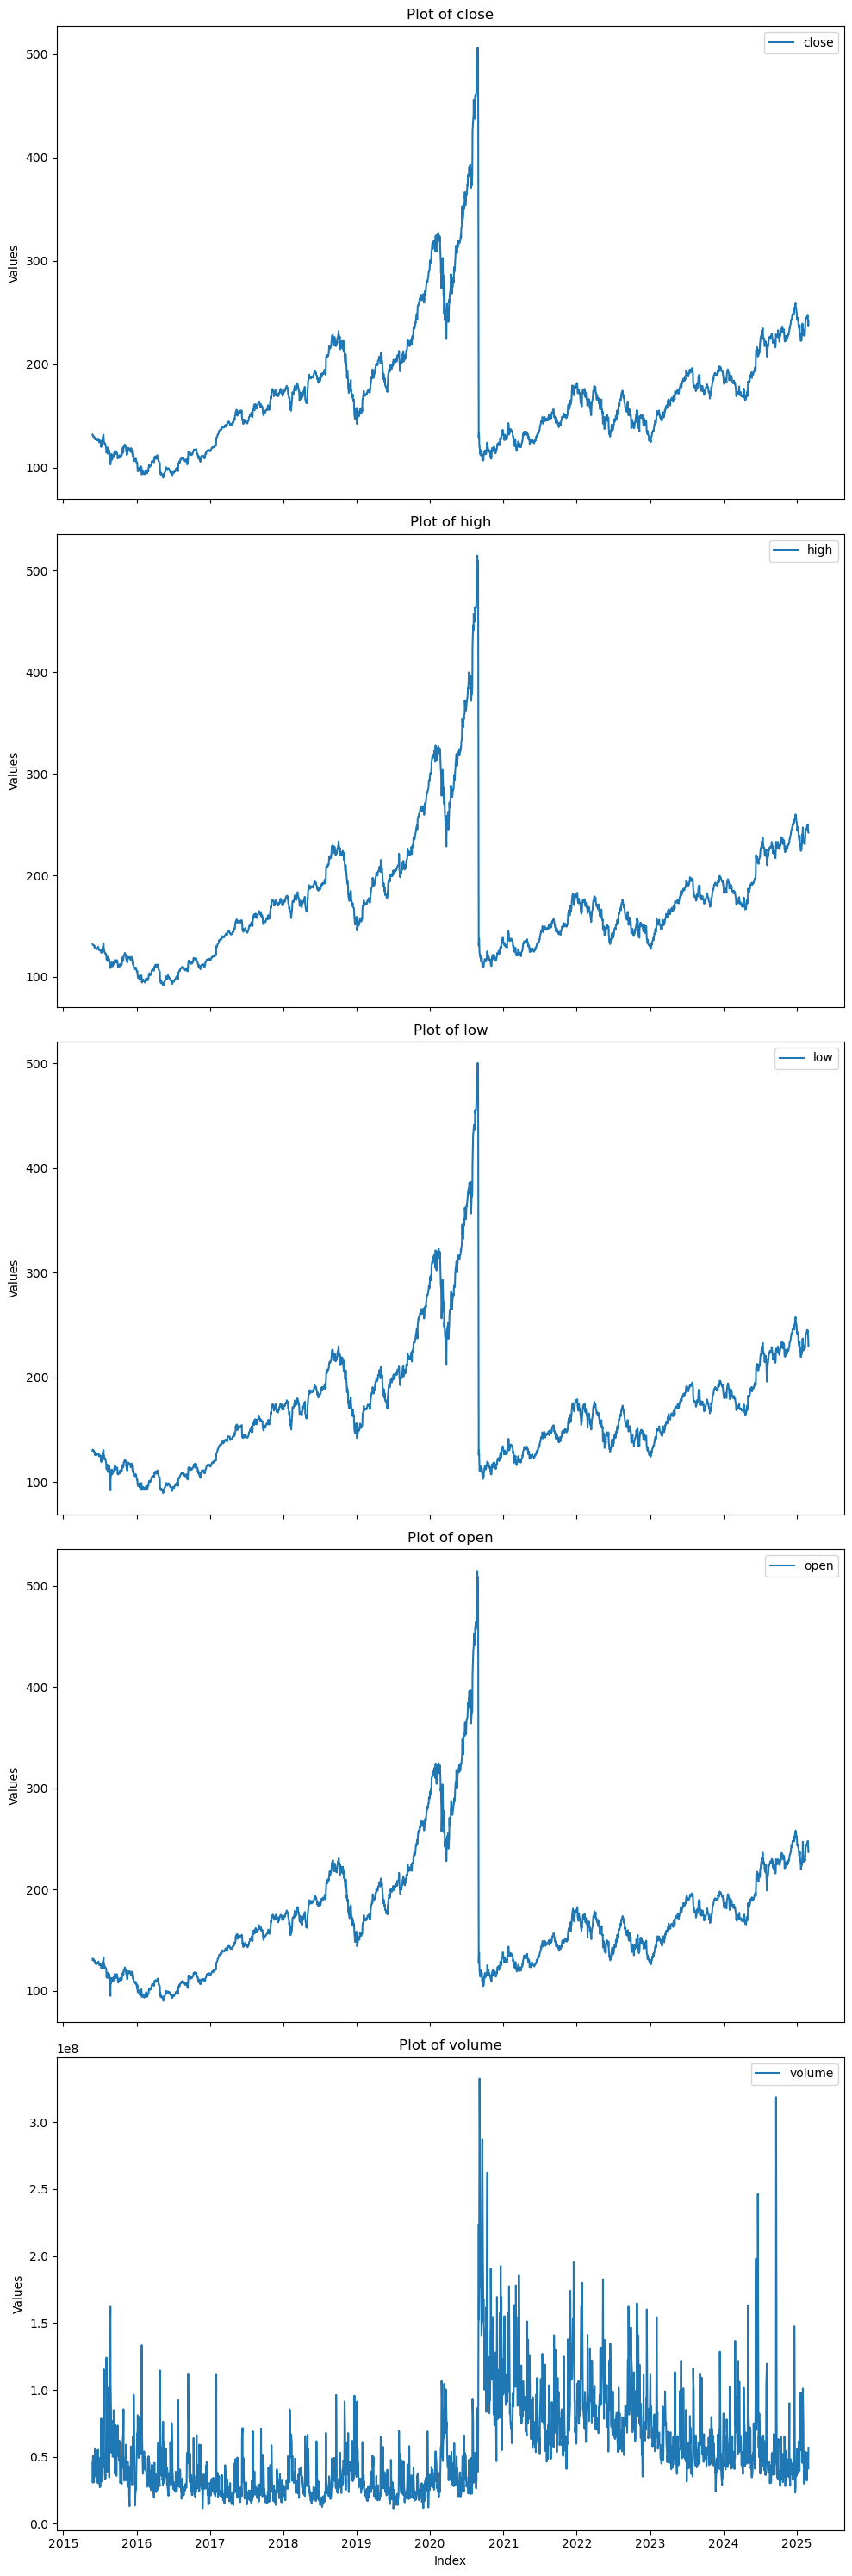

In [26]:
# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = df.toPandas()

# Ensure 'numerical' is a list of numerical column names
n_numerical = len(numerical)

# Create subplots for each numerical column
fig, axes = plt.subplots(n_numerical, 1, figsize=(10, 6 * n_numerical), sharex=True)

# If there's only one numerical column, make axes iterable
if n_numerical == 1:
    axes = [axes]

for ax, col in zip(axes, numerical):
    ax.plot(df_pandas['date'], df_pandas[col], label=col)
    ax.set_ylabel("Values")
    ax.set_title(f"Plot of {col}")
    ax.legend()

plt.xlabel("Index")
plt.tight_layout()
plt.show()


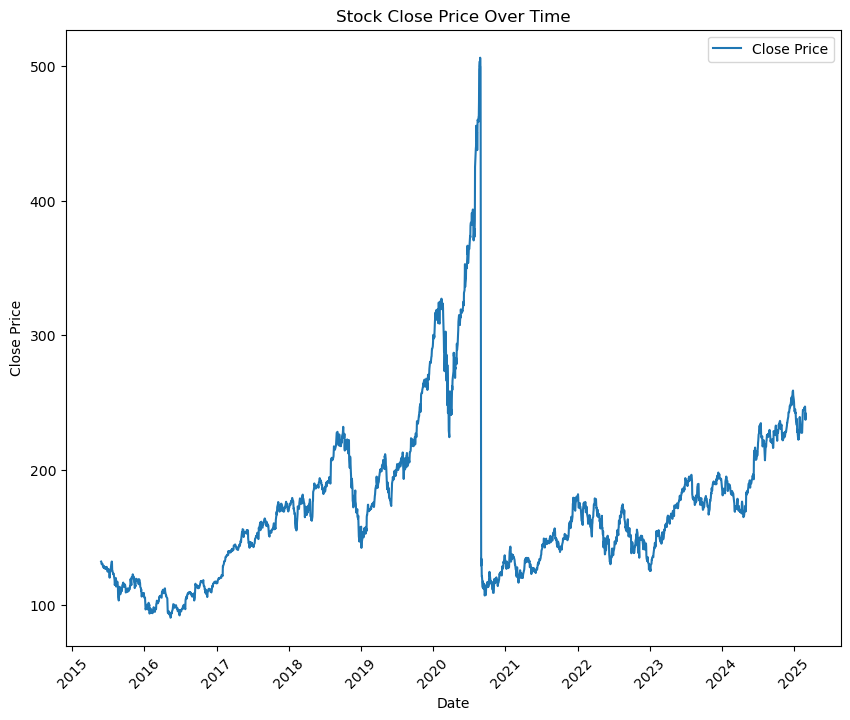

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns  

fig = plt.figure(figsize=(10, 8))
plt.plot(df_pandas['date'], df_pandas['close'], label='Close Price')  # Specifying x and y values
plt.xlabel('Date')  # X-axis label
plt.ylabel('Close Price')  # Y-axis label
plt.title('Stock Close Price Over Time')  # Adding a title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Displaying the legend
plt.show()


In [28]:
# As the df is no longer needed for computation, us .unpersist() to free memory 
df.unpersist()

DataFrame[date: date, close: float, high: float, low: float, open: float, volume: float, adjClose: float, adjHigh: float, adjLow: float, adjOpen: float, adjVolume: float, divCash: float, splitFactor: float]

In [ ]:
print(rdd1.toDebugString())

b'(1) MapPartitionsRDD[190] at javaToPython at NativeMethodAccessorImpl.java:0 []\n |  MapPartitionsRDD[189] at javaToPython at NativeMethodAccessorImpl.java:0 []\n |  SQLExecutionRDD[188] at javaToPython at NativeMethodAccessorImpl.java:0 []\n |  MapPartitionsRDD[187] at javaToPython at NativeMethodAccessorImpl.java:0 []\n |  MapPartitionsRDD[186] at javaToPython at NativeMethodAccessorImpl.java:0 []\n |  MapPartitionsRDD[185] at javaToPython at NativeMethodAccessorImpl.java:0 []\n |  FileScan csv [date#1,close#2,high#3,low#4,open#5,volume#6,adjClose#7,adjHigh#8,adjLow#9,adjOpen#10,adjVolume#11,divCash#12,splitFactor#13] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[hdfs://localhost:9000/user1/stock_data.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<date:date,close:float,high:float,low:float,open:float,volume:float,adjClose:float,adjHigh:...\n MapPartitionsRDD[3] at showString at NativeMethodAccessorImpl.java:0 []\n |  MapPartit

In [31]:
# Reset the index (optional, if needed)
df1 = df_pandas[['close','date']]
print(type(df1))  #
# Optionally, save it to a CSV file
df1.head()

<class 'pandas.core.frame.DataFrame'>


,close,date
0,132.044998,2015-05-27
1,131.779999,2015-05-28
2,130.279999,2015-05-29
3,130.535004,2015-06-01
4,129.960007,2015-06-02


In [32]:
# saving the final df 
df1.to_csv("final_df.csv", index=False)